In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import sys
import os
sys.path.append('../')
from cxr_fairness.plot_utils import binary_metrics, get_bootstrapped_metrics
from cxr_fairness.data import data
from cxr_fairness.data import Constants
import seaborn as sns
from matplotlib.ticker import PercentFormatter

pd.set_option('display.max_columns', None)

class smart_dict(dict):
    def __missing__(self, key):
        return key 
    
grp_name_mapping = smart_dict({
    'F': "Female",
    'M': 'Male',
    0: 'White',
    1: 'Black',
    2: "Other"
})

In [2]:
cohort_dict = data.load_df('MIMIC', '0', only_frontal = False)

In [3]:
cohort = pd.concat((cohort_dict['train'], cohort_dict['val'], cohort_dict['test']))

In [4]:
df = pd.read_excel('../aux_data/MIMIC_CXR_Rad_Labels.xlsx', engine = 'openpyxl')[['subject_id', 'study_id', 'No Finding?']]

In [5]:
df['subject_id'] = df['subject_id'].astype(str)
df['study_id'] = df['study_id'].astype(str)

In [6]:
df = df.merge(cohort[['subject_id', 'study_id', 'No Finding', 'sex', 'age', 'ethnicity']].drop_duplicates(), 
              on = ['subject_id', 'study_id'], how = 'left')

In [9]:
df = df.loc[df['No Finding'] == 1] # remove 3 samples that have no No Finding that somehow got in

In [11]:
attrs = ['sex', 'ethnicity', 'age']
order = ['Male', 'Female', 'White', 'Black', 'Other', '18-40', '40-60', '60-80', '80-']

In [12]:
for attr in attrs:
    df[attr] = df[attr].map(grp_name_mapping)

/h/haoran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
all_dfs = []
for c, attr1 in enumerate(attrs):
    for attr2_idx in range(c, len(attrs)):
        attr2 = attrs[attr2_idx]
        print(attr1, attr2)
        if attr1 == attr2:
            boot_df = (get_bootstrapped_metrics(df, attrs = [attr1], n_boot = 500, pred_col = 'No Finding', target_col = 'No Finding?')
                      .reset_index().rename(columns = {
                'level_0': 'metric', 
                'level_1': 'group1'
            }))
            boot_df['group2'] = boot_df['group1']
        else:
            df[f'{attr1}_{attr2}'] = df[attr1] + '_' + df[attr2]
            boot_df = (get_bootstrapped_metrics(df, attrs = [f'{attr1}_{attr2}'], n_boot = 500, pred_col = 'No Finding', target_col = 'No Finding?')
                      .reset_index().rename(columns = {
                'level_0': 'metric',
            }))
            boot_df['group1'] = boot_df['level_1'].apply(lambda x: x.split('_')[0])
            boot_df['group2'] = boot_df['level_1'].apply(lambda x: x.split('_')[1])
            boot_df = boot_df.drop(columns = ['level_1'])
            
        all_dfs.append(boot_df[boot_df.metric == 'accuracy'])

sex sex
sex ethnicity


/h/haoran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


sex age
ethnicity ethnicity
ethnicity age
age age


In [14]:
boot_df = pd.concat(all_dfs).reset_index(drop = True)

In [15]:
draw_df = boot_df.pivot_table(index = 'group1', columns = 'group2', values = 'mean', aggfunc = lambda x: x).loc[order, order]

In [16]:
lower_df = boot_df.pivot_table(index = 'group1', columns = 'group2', values = 'lower', aggfunc = lambda x: x).loc[order, order]
upper_df = boot_df.pivot_table(index = 'group1', columns = 'group2', values = 'upper', aggfunc = lambda x: x).loc[order, order]

In [17]:
text_df = (draw_df.apply(lambda x: x.map("{0:.1%}".format)) + '\n(' + lower_df.apply(lambda x: x.map("{0:.1%}".format)) + ', ' 
     + upper_df.apply(lambda x: x.map("{0:.1%}".format) + ')'))

In [18]:
heatmap_mask = pd.isnull(draw_df)

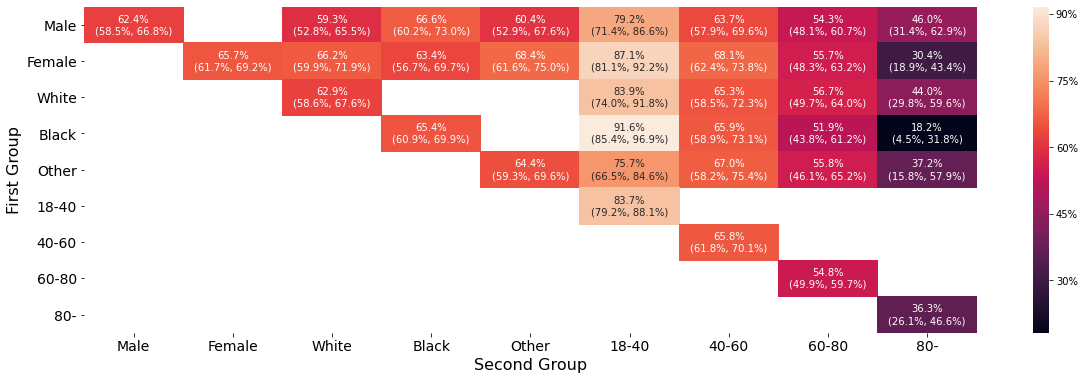

In [26]:
# with CIs
fig, ax = plt.subplots(figsize = (20, 6))
ax = sns.heatmap(draw_df, annot = text_df.values, mask = heatmap_mask.values, ax = ax, fmt = '', square = False)
ax.set_xlabel('Second Group', fontsize = 16)
ax.set_ylabel('First Group', fontsize = 16)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.yticks(rotation = 0) 
fig.savefig('./cxr_debias_figures/rad_labels_with_CIs.pdf', dpi = 400, bbox_inches = 'tight')
plt.show()

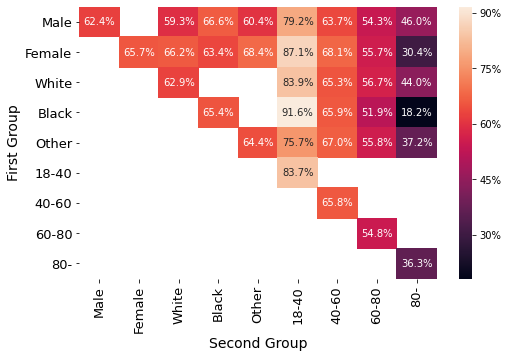

In [20]:
# without CIs
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.heatmap(draw_df, annot = (draw_df.apply(lambda x: x.map("{0:.1%}".format))).values, mask = heatmap_mask.values, ax = ax, fmt = '', square = False)
ax.set_xlabel('Second Group', fontsize = 14)
ax.set_ylabel('First Group', fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
plt.xticks(rotation = 90) 
fig.savefig('./cxr_debias_figures/rad_labels_without_CIs.pdf', dpi = 400, bbox_inches = 'tight')
plt.show()

In [21]:
df['No Finding?'].sum()/len(df)

0.6407685881370092